## In this Notebook a model is set up and trained on filtered data (uniform backgroud per disease) not very successfull and dismissed.
### however, the model will be tested in the end on external data, so the notebook might be used for this


In [1]:
#Import nessesary packages, libraries and global variables

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from  PIL import Image
import numpy as np
from tensorflow.keras import Input, Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import split_dataset
import tensorflow as tf
from tensorflow import keras

#import sys
#sys.path.append('../modeling')

RSEED = 42
dataset_path = '../data/filtered/train/'

In [2]:
def load_preprocess_split_train_val(data_path):
    ''' 
    Function needs filefath as parameter, it will create a validation dataset of 20% of the total df, 
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image = tf.keras.utils.image_dataset_from_directory(
        data_path, 
        validation_split = 0.2,
        subset = "both", 
        seed = RSEED,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical'
    )
    return image 

In [3]:
train_ds, val_ds = load_preprocess_split_train_val(dataset_path)

Found 46155 files belonging to 25 classes.
Using 36924 files for training.
Using 9231 files for validation.


2024-02-20 13:46:27.663319: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-20 13:46:27.663347: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-20 13:46:27.663355: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-20 13:46:27.663517: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-20 13:46:27.663777: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
import tensorflow.keras.backend as K
K.clear_session()

In [5]:
#define model

model = keras.applications.EfficientNetB0(
    include_top=False
)

In [6]:
#get overview of the model architecture

model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [7]:
from keras import layers
IMG_SIZE = 224
BATCH_SIZE = 32

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)) # Define the input layer with the shape of input images
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet") # Load the EfficientNetB0 model pretrained on ImageNet without the top classification layer
                                                                                        # Use the input layer defined above

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output) # Apply global average pooling to the output of the base layers
    x = layers.BatchNormalization()(x) # Apply batch normalization to normalize the activations of the previous layer


    top_dropout_rate = 0.2 # Define the dropout rate
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x) # Apply dropout regularization to the previous layer
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x) # Add a dense layer for classification with softmax activation

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet") # Construct the final model with the specified input and output layers
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-2) # Define the optimizer with a learning rate of 0.01 using the Adam optimizer
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return model

In [8]:
model = build_model(num_classes=25)

In [9]:
epochs = 10
#history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [11]:
#next we want to unfreeze 10 layers and retrain 

import tensorflow as tf

def unfreeze_model_and_clone(model):
    # Clone the original model
    unfrozen_model = tf.keras.models.clone_model(model)
    unfrozen_model.set_weights(model.get_weights())  # Copy weights

    # Unfreeze the top 10 layers while leaving BatchNorm layers frozen
    for layer in unfrozen_model.layers[-10:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)
    unfrozen_model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return unfrozen_model


In [21]:
# Create a new model with unfrozen layers
unfrozen_model2 = unfreeze_model_and_clone(model)

epochs = 10

history2 = unfrozen_model2.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
1154/1154 [==============================] - ETA: 0s - loss: 1.9258 - accuracy: 0.4968

KeyboardInterrupt: 

In [13]:
import matplotlib.pyplot as plt

def plot_training_metrics(history):
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

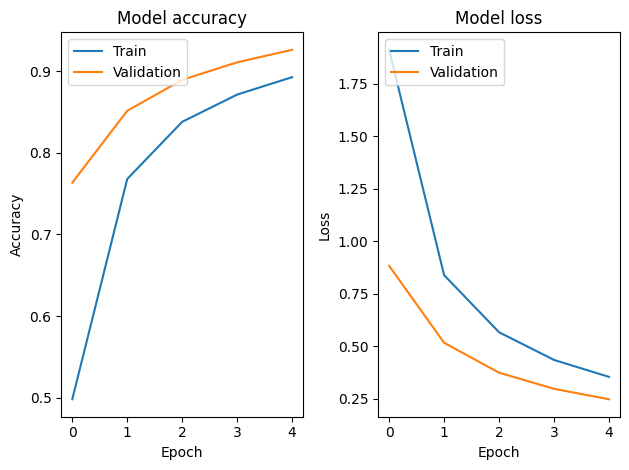

In [23]:
plot_training_metrics(history2)

In [45]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def load_test(data_path):
    ''' 
    Function needs filepath as parameter, it will create a validation dataset of 20% of the total df, 
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image_dataset = tf.keras.utils.image_dataset_from_directory(
        data_path,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical',
        shuffle = False
    )
    return image_dataset 

dataset_test_path = '../data/filtered/test/'

In [49]:
test_ds = load_test(dataset_test_path)

Found 11539 files belonging to 25 classes.


In [17]:
#check an example 
test_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 25), dtype=tf.float32, name=None))>

In [22]:
# Make predictions on the test dataset
predictions = unfrozen_model2.predict(test_ds)

 14/361 [>.............................] - ETA: 1:22

KeyboardInterrupt: 

#### Plotting the results and getting evaluation metrics

In [75]:
# Step 1: Get the true labels from the test dataset
y_true = []
for filepath in test_ds.file_paths:
    label = os.path.basename(os.path.dirname(filepath))
    y_true.append(label)

# Extract unique class labels from your training data
classes = sorted(set(y_true))

# Step 2: Convert true labels to indices using the same mapping used during training
class_to_index = {cls: i for i, cls in enumerate(classes)}
y_true_indices = np.array([class_to_index[label] for label in y_true])

# Step 3: Use your model to make predictions on the test dataset
#y_pred_probabilities = unfrozen_model2.predict(test_ds)

# Step 4: Convert the predicted class probabilities to class labels
#y_pred_indices = np.argmax(y_pred_probabilities, axis=1)
#y_pred = [classes[i] for i in y_pred_indices]

# Step 5: Generate the classification report
#report = classification_report(y_true, y_pred)
#print("Classification Report:")
#print(report)



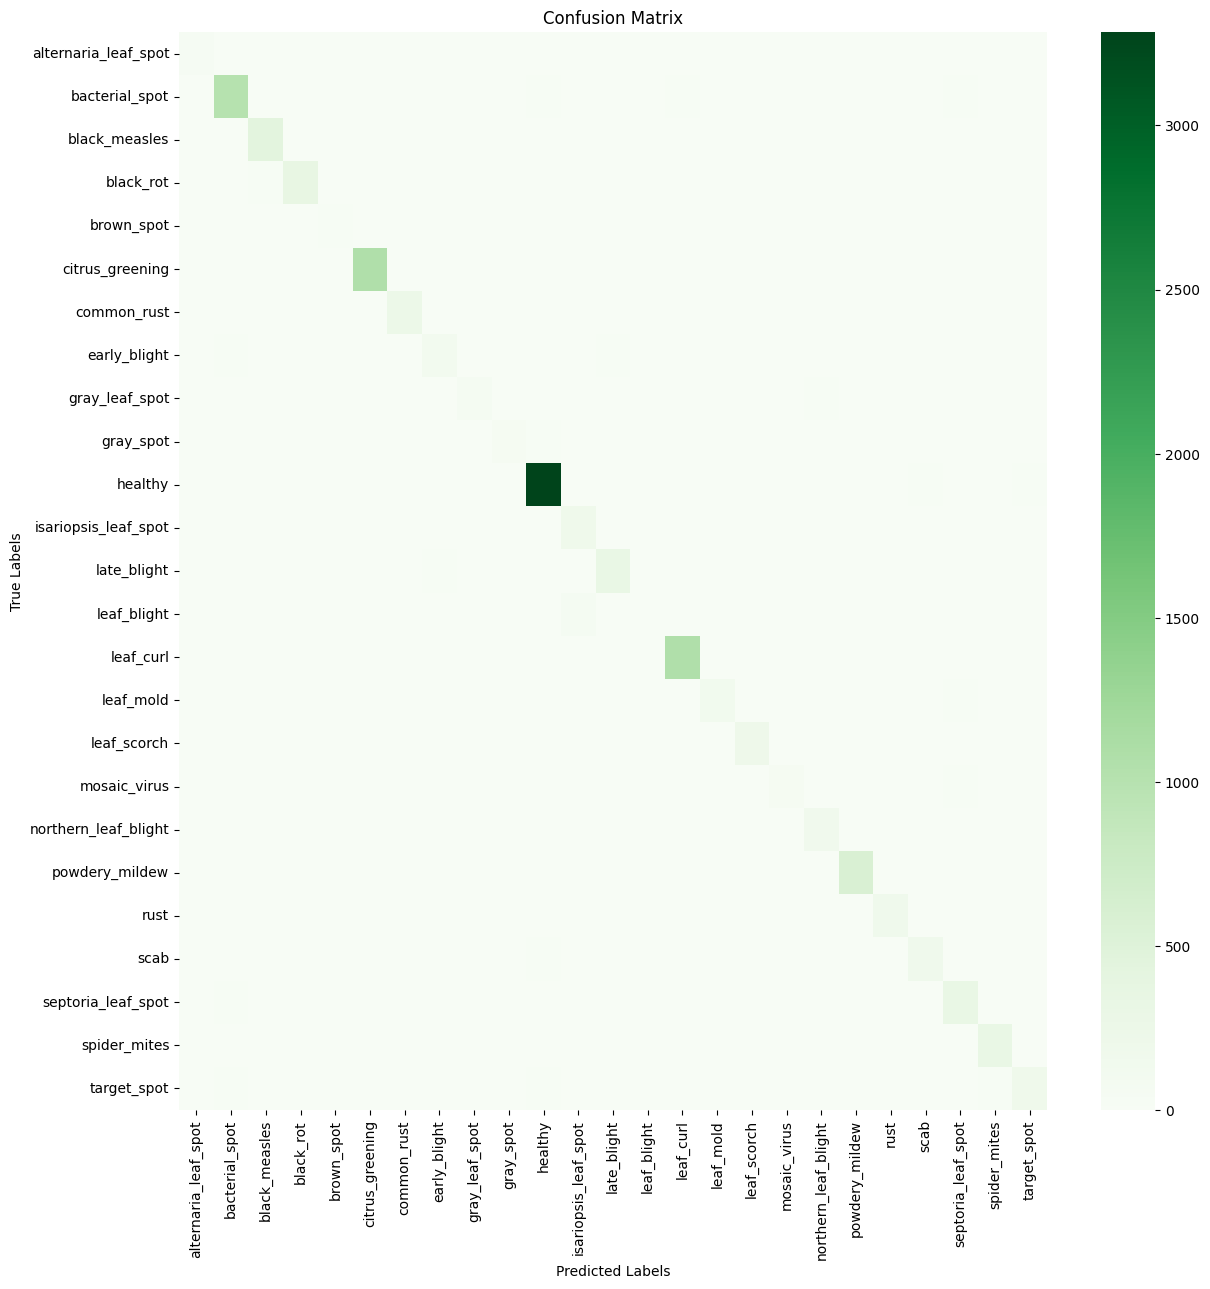

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix using seaborn heatmap with green color palette
plt.figure(figsize=(14, 14))
sns.heatmap(cm, annot=False, cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Now we try with external data

In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def load_test(data_path):
    ''' 
    Function needs filepath as parameter, it will create a validation dataset of 20% of the total df, 
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image_dataset = tf.keras.utils.image_dataset_from_directory(
        data_path,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical',
        shuffle = False
    )
    return image_dataset 

dataset_test_test_path = '../data/filtered/test_test/'

In [51]:
test_test_ds = load_test(dataset_test_test_path)


Found 2 files belonging to 2 classes.


In [86]:
# Assuming test_test_ds is your test dataset containing images from two classes

# Step 1: Use your model to make predictions on the test dataset
#y_pred_test_probabilities = unfrozen_model2.predict(test_test_ds)
#y_pred_test_probabilities = unfrozen_model2.predict(test_test_ds)
# Load model from disc
model3 = keras.models.load_model('../models/unfrozen_model_mod_3.h5')

y_pred_test_probabilities = model3.predict(test_test_ds)

# Step 2: Find the class index with the highest probability for each sample
y_pred_test_indices = np.argmax(y_pred_test_probabilities, axis=1)

# Step 3: Map the predicted indices to class labels
predicted_classes = [classes[i] for i in y_pred_test_indices]

# Now, predicted_classes contains the predicted class labels for the images in your test dataset.


1/1 [==============================] - 3s 3s/step


In [87]:
predicted_classes

['gray_leaf_spot', 'black_measles']

In [79]:
y_pred_test_indices

array([21,  8])